In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.utils import class_weight

from sklearn.preprocessing import label_binarize

In [2]:
# Parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
EPOCHS = 30
TRAIN_DIR = "../../data5/train"
TEST_DIR = "../../data5/test"

# Create data generators with IncptionV3-specific preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen  = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_generator.num_classes
class_labels = list(train_generator.class_indices.keys())

print("Number of classes:", num_classes)
print("Class labels:", class_labels)
# Compute Class Weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

Found 5999 images belonging to 4 classes.
Found 2576 images belonging to 4 classes.
Number of classes: 4
Class labels: ['Acne', 'Eczema', 'Infection', 'Malignant']


In [3]:
# Load InceptionV3 pretrained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False,
                   input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Freeze the initial layers
for layer in base_model.layers[:10]:
    layer.trainable = False

# Build a new classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)  
x = BatchNormalization()(x)  
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  
predictions = Dense(num_classes, activation='softmax', dtype='float32')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

87910968/87910968 [==============================] - 7s 0us/step


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [4]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    verbose=1,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/30
47/47 [==============================] - 519s 11s/step - loss: 1.2425 - accuracy: 0.5753 - val_loss: 1.0775 - val_accuracy: 0.5998 - lr: 1.0000e-04
Epoch 2/30
47/47 [==============================] - 536s 11s/step - loss: 0.8052 - accuracy: 0.6931 - val_loss: 0.9205 - val_accuracy: 0.7073 - lr: 1.0000e-04
Epoch 3/30
47/47 [==============================] - 539s 11s/step - loss: 0.6398 - accuracy: 0.7428 - val_loss: 0.6493 - val_accuracy: 0.7547 - lr: 1.0000e-04
Epoch 4/30
47/47 [==============================] - 593s 13s/step - loss: 0.5494 - accuracy: 0.7896 - val_loss: 0.5802 - val_accuracy: 0.7853 - lr: 1.0000e-04
Epoch 5/30
47/47 [==============================] - 589s 12s/step - loss: 0.4725 - accuracy: 0.8171 - val_loss: 0.5729 - val_accuracy: 0.7865 - lr: 1.0000e-04
Epoch 6/30
47/47 [==============================] - 594s 13s/step - loss: 0.4013 - accuracy: 0.8425 - val_loss: 0.5603 - val_accuracy: 0.8005 - lr: 1.0000e-04
Epoch 7/30
47/47 [============================

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
callbacks = [early_stopping, lr_scheduler, checkpoint]

In [6]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


21/21 [==============================] - 51s 2s/step - loss: 0.7700 - accuracy: 0.8463
Test Loss: 0.7699926495552063, Test Accuracy: 0.8462733030319214


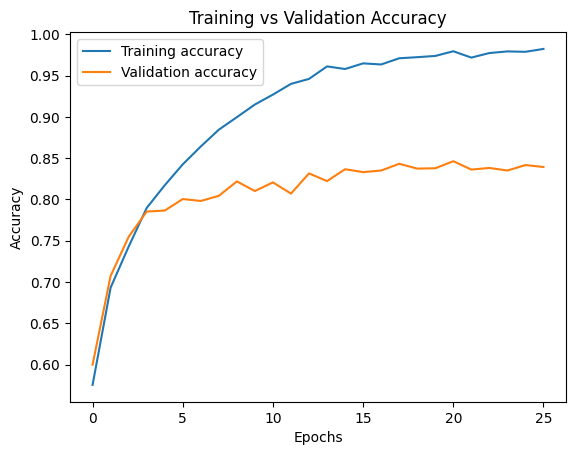

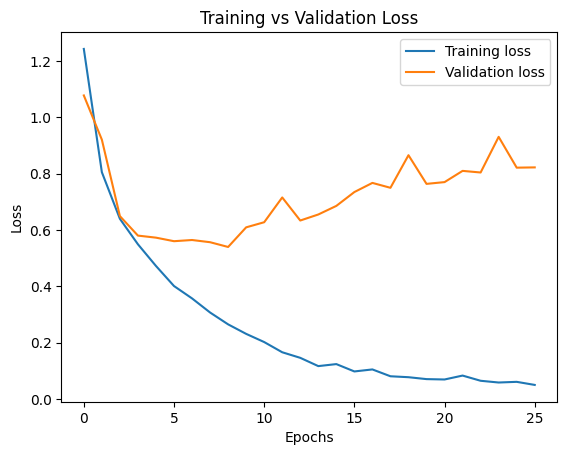

In [7]:
def plot_training_results(history, metrics=["accuracy", "loss"]):
    for metric in metrics:
        plt.figure()
        plt.plot(history.history[metric], label=f"Training {metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
        plt.title(f"Training vs Validation {metric.capitalize()}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

plot_training_results(history, metrics=["accuracy", "loss"])

21/21 [==============================] - 51s 2s/step

Classification Report:
              precision    recall  f1-score   support

        Acne       0.90      0.91      0.91       626
      Eczema       0.79      0.81      0.80       650
   Infection       0.75      0.80      0.77       650
   Malignant       0.95      0.88      0.91       650

    accuracy                           0.85      2576
   macro avg       0.85      0.85      0.85      2576
weighted avg       0.85      0.85      0.85      2576

Confusion Matrix:
[[569  27  27   3]
 [ 18 525  96  11]
 [ 31  87 517  15]
 [ 11  23  47 569]]


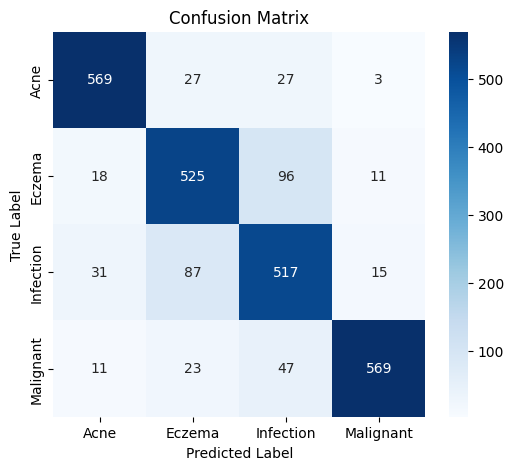

In [8]:
import seaborn as sns 
# Predict class probabilities
y_pred_probs = model.predict(test_generator)
# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels from the test generator
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

Macro-average ROC AUC: 0.9612942145829713
Micro-average ROC AUC: 0.9655035321666473


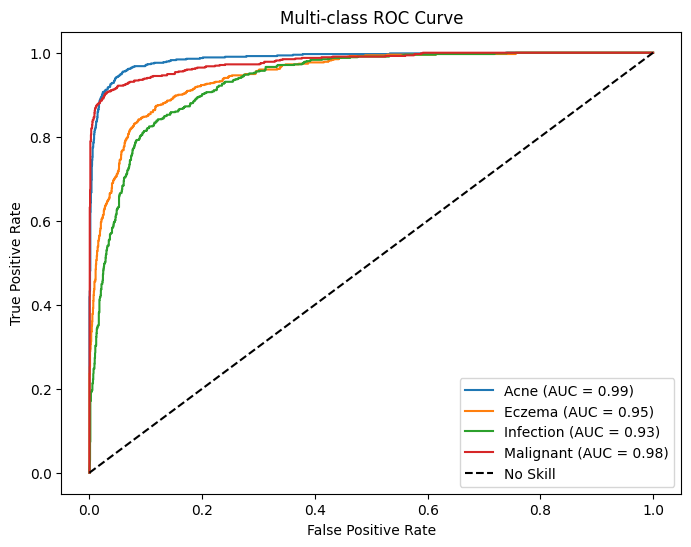

In [9]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
y_true_indices = test_generator.classes

# 8. Multi-class ROC & AUC
y_true_binarized = label_binarize(y_true_indices, classes=range(num_classes))

macro_roc_auc = roc_auc_score(y_true_binarized, y_pred_probs, 
                              multi_class='ovr', average='macro')
micro_roc_auc = roc_auc_score(y_true_binarized, y_pred_probs, 
                              multi_class='ovr', average='micro')
print("Macro-average ROC AUC:", macro_roc_auc)
print("Micro-average ROC AUC:", micro_roc_auc)

fpr = {}
tpr = {}
roc_auc_classwise = {}

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc_classwise[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label='{} (AUC = {:.2f})'.format(class_labels[i], roc_auc_classwise[i]))

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [10]:
model.save("../../models/hybrid_model_inceptionV3_beforeFinTune_new128.keras")

In [11]:
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.regularizers import l2

# Fine-tuning learning rate
FINE_TUNE_LEARNING_RATE = 1e-5

# Add L2 regularization to the existing dense output layer
# Access the last dense layer and modify its kernel regularizer
for layer in model.layers:
    if isinstance(layer, Dense):
        layer.kernel_regularizer = l2(0.01)  # Apply L2 regularization

# Recompile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=FINE_TUNE_LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
history_finetune = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=15,  # Fine-tuning typically requires fewer epochs
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/15
47/47 [==============================] - 510s 11s/step - loss: 0.0438 - accuracy: 0.9838 - val_loss: 0.7769 - val_accuracy: 0.8470 - lr: 1.0000e-05
Epoch 2/15
47/47 [==============================] - 508s 11s/step - loss: 0.0412 - accuracy: 0.9865 - val_loss: 0.7620 - val_accuracy: 0.8494 - lr: 1.0000e-05
Epoch 3/15
47/47 [==============================] - 508s 11s/step - loss: 0.0413 - accuracy: 0.9885 - val_loss: 0.7707 - val_accuracy: 0.8474 - lr: 1.0000e-05
Epoch 4/15
47/47 [==============================] - 501s 11s/step - loss: 0.0356 - accuracy: 0.9903 - val_loss: 0.7866 - val_accuracy: 0.8447 - lr: 1.0000e-05
Epoch 5/15
47/47 [==============================] - 513s 11s/step - loss: 0.0334 - accuracy: 0.9893 - val_loss: 0.7715 - val_accuracy: 0.8455 - lr: 1.0000e-05
Epoch 6/15
47/47 [==============================] - 501s 11s/step - loss: 0.0308 - accuracy: 0.9888 - val_loss: 0.7894 - val_accuracy: 0.8451 - lr: 1.0000e-05
Epoch 7/15
47/47 [============================

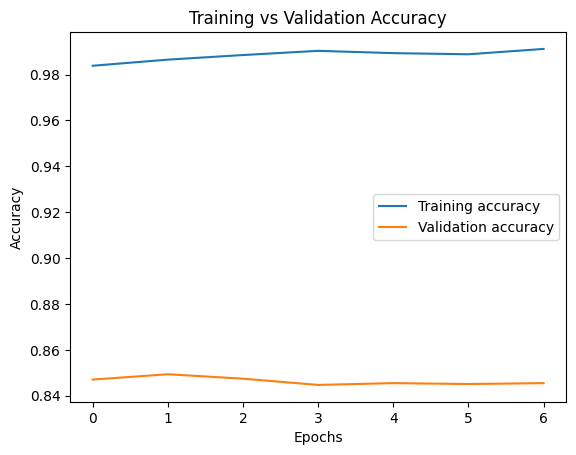

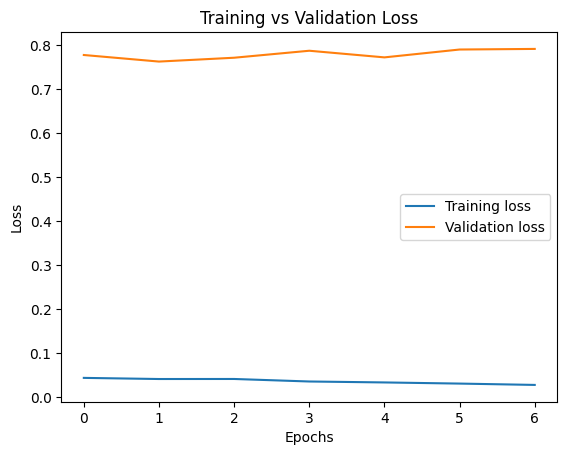

In [12]:
def plot_training_results(history, metrics=["accuracy", "loss"]):
    for metric in metrics:
        plt.figure()
        plt.plot(history.history[metric], label=f"Training {metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
        plt.title(f"Training vs Validation {metric.capitalize()}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

plot_training_results(history_finetune, metrics=["accuracy", "loss"])

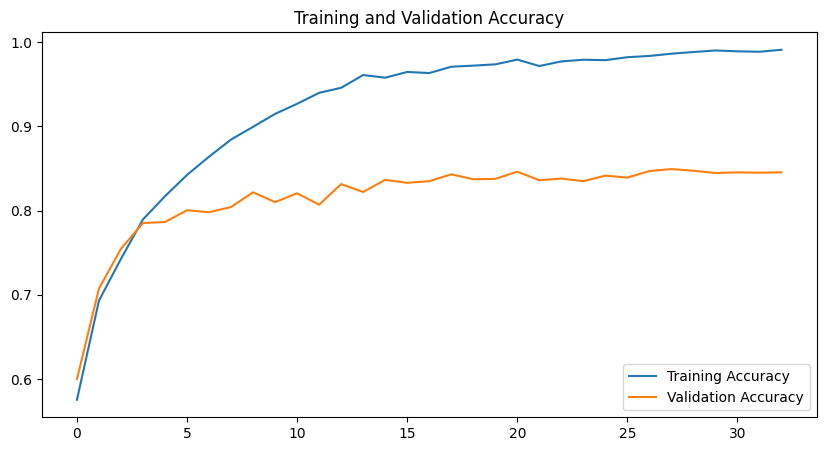

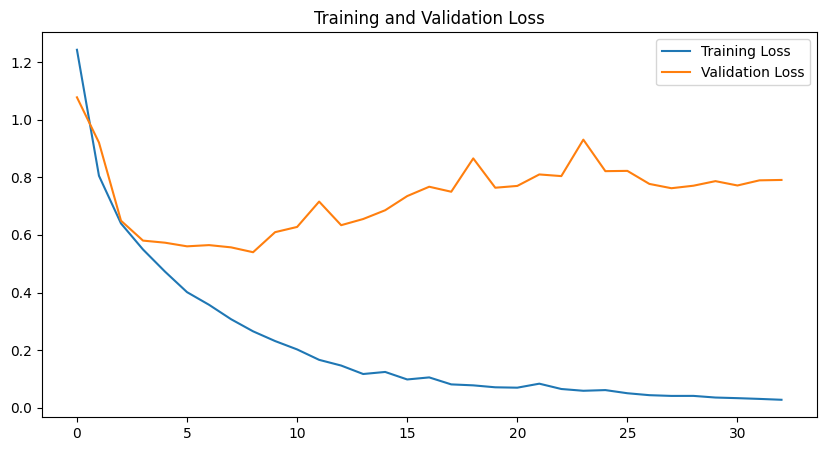

In [21]:
# Plot Training and Validation Accuracy
def plot_training_results(history, fine_tune_history):
    acc = history.history['accuracy'] + fine_tune_history.history['accuracy']
    val_acc = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']

    loss = history.history['loss'] + fine_tune_history.history['loss']
    val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_training_results(history, history_finetune)

21/21 [==============================] - 55s 3s/step

Classification Report:
              precision    recall  f1-score   support

        Acne       0.91      0.90      0.91       626
      Eczema       0.79      0.83      0.81       650
   Infection       0.76      0.78      0.77       650
   Malignant       0.95      0.88      0.92       650

    accuracy                           0.85      2576
   macro avg       0.85      0.85      0.85      2576
weighted avg       0.85      0.85      0.85      2576

Confusion Matrix:
[[566  23  34   3]
 [ 19 541  83   7]
 [ 27  98 508  17]
 [  8  26  43 573]]


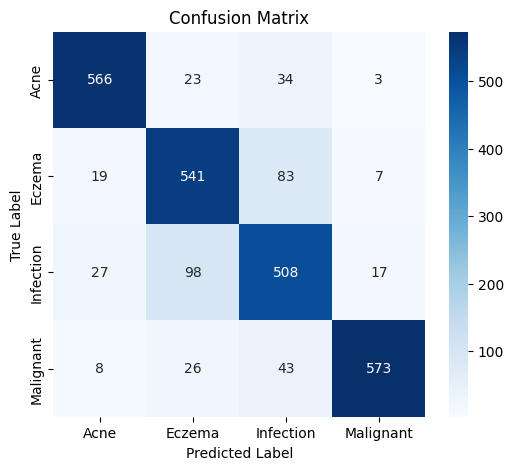

In [13]:
import seaborn as sns 
# Predict class probabilities
y_pred_probs = model.predict(test_generator)
# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels from the test generator
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

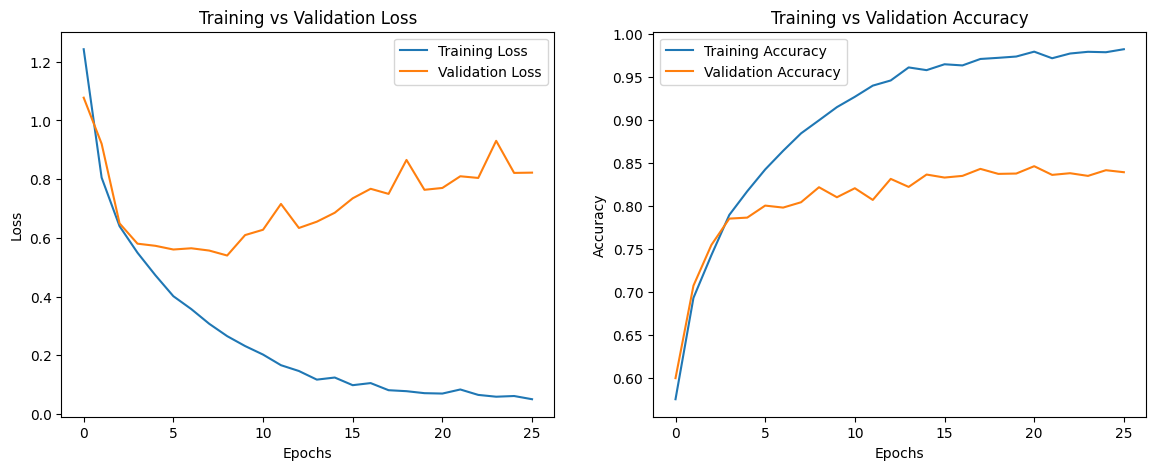

In [14]:
train_loss = history.history['loss']
train_acc  = history.history['accuracy']
val_loss   = history.history['val_loss']
val_acc    = history.history['val_accuracy']

epochs_range = range(len(train_loss))

plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss,   label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc,   label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


In [15]:
train_loss, train_accuracy = model.evaluate(train_generator, verbose=0)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)


Train Loss: 0.016876477748155594
Train Accuracy: 0.9953325390815735


In [ ]:
# 6. Evaluate on Test Set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Val Loss:", test_loss)
print("Val Accuracy:", test_accuracy)

In [16]:
model.save("../../models/hybrid_model_inceptionV3_new128_afterFineTune.keras")

Macro-average ROC AUC: 0.9666894882079557
Micro-average ROC AUC: 0.9702893075353959


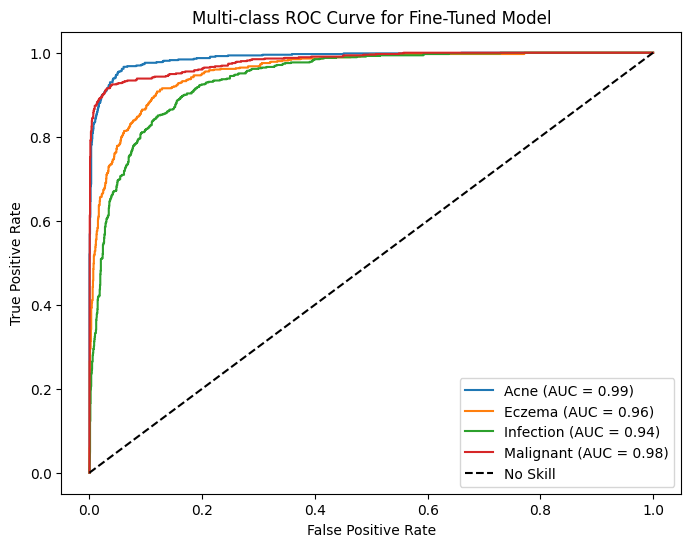

In [17]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
y_true_indices = test_generator.classes

# 8. Multi-class ROC & AUC
y_true_binarized = label_binarize(y_true_indices, classes=range(num_classes))

macro_roc_auc = roc_auc_score(y_true_binarized, y_pred_probs, 
                              multi_class='ovr', average='macro')
micro_roc_auc = roc_auc_score(y_true_binarized, y_pred_probs, 
                              multi_class='ovr', average='micro')
print("Macro-average ROC AUC:", macro_roc_auc)
print("Micro-average ROC AUC:", micro_roc_auc)

fpr = {}
tpr = {}
roc_auc_classwise = {}

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc_classwise[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label='{} (AUC = {:.2f})'.format(class_labels[i], roc_auc_classwise[i]))

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve for Fine-Tuned Model')
plt.legend(loc='lower right')
plt.show()

In [22]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import pickle

# Constants
BATCH_SIZE = 128  # Replace with your actual batch size
  # Path to save the model

# Function to Extract Features and Labels
def extract_features_and_labels(generator, base_model, batch_size):
    features = []
    labels = []
    for batch_images, batch_labels in generator:
        features.append(base_model.predict(batch_images, verbose=0))  # Extract features
        labels.append(batch_labels)
        # Stop when all samples are processed
        if len(features) * batch_size >= generator.samples:
            break
    features = np.vstack(features)  # Stack features vertically
    labels = np.vstack(labels)      # Stack labels vertically
    return features, labels

# Step 1: Extract Features and Labels from Training Data
print("Extracting features and labels for training...")
train_features, train_labels = extract_features_and_labels(train_generator, base_model, BATCH_SIZE)

# Extract Features and Labels from Test Data
print("Extracting features and labels for testing...")
test_features, test_labels = extract_features_and_labels(test_generator, base_model, BATCH_SIZE)

# Step 2: Convert One-Hot Encoded Labels to Integers
train_labels = np.argmax(train_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)

# Step 3: Flatten Features for Random Forest
print("Flattening features for Random Forest...")
X_train = train_features.reshape(train_features.shape[0], -1)
X_test = test_features.reshape(test_features.shape[0], -1)

# Step 4: Define and Train Random Forest with Grid Search
print("Training Random Forest with Grid Search...")
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train, train_labels)

# Get the best model from grid search
best_rf = grid_search.best_estimator_

# Step 5: Evaluate the Model
print("Evaluating the model...")
y_pred = best_rf.predict(X_test)

print("Classification Report:")
print(classification_report(test_labels, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(test_labels, y_pred))

# Step 6: Save the Model
MODEL_SAVE_PATH = '../../models/hybrid_rf_inceptionsV3_model_128.pkl'
print(f"Saving the model to {MODEL_SAVE_PATH}...")
with open(MODEL_SAVE_PATH, 'wb') as file:
    pickle.dump(best_rf, file)

print("Model saved successfully.")


Extracting features and labels for training...
Extracting features and labels for testing...
Flattening features for Random Forest...
Training Random Forest with Grid Search...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Evaluating the model...
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       626
           1       0.76      0.82      0.79       650
           2       0.74      0.74      0.74       650
           3       0.96      0.87      0.91       650

    accuracy                           0.83      2576
   macro avg       0.83      0.83      0.83      2576
weighted avg       0.83      0.83      0.83      2576

Confusion Matrix:
[[563  24  36   3]
 [ 25 531  88   6]
 [ 38 116 480  16]
 [ 14  26  47 563]]
Saving the model to ../../models/hybrid_rf_vgg16_model_128.pkl...
Model saved successfully.


In [23]:
# Step 6: Save the Model
MODEL_SAVE_PATH = '../../models/hybrid_rf_inceptionsV3_model_128_override.pkl'
print(f"Saving the model to {MODEL_SAVE_PATH}...")
with open(MODEL_SAVE_PATH, 'wb') as file:
    pickle.dump(best_rf, file)

print("Model saved successfully.")

Saving the model to ../../models/hybrid_rf_inceptionsV3_model_128_override.pkl...
Model saved successfully.


Confusion Matrix:
[[563  24  36   3]
 [ 25 531  88   6]
 [ 38 116 480  16]
 [ 14  26  47 563]]


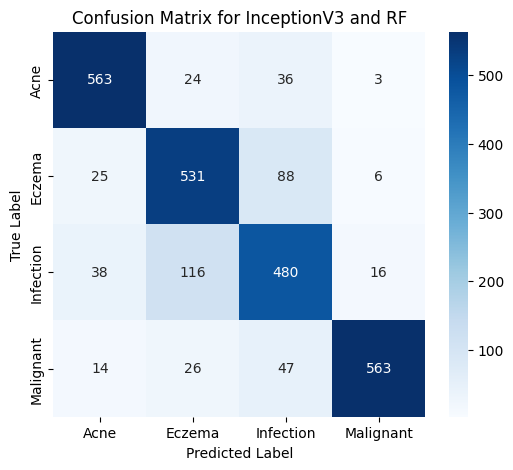

In [24]:

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix for InceptionV3 and RF")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [ ]:
from sklearn.decomposition import PCA
import joblib

pca = PCA(n_components=128)  # Dimensionality reduction

# Flatten the data
X_train_flat = train_features.reshape(X_train.shape[0], -1)
X_test_flat = test_features.reshape(X_test.shape[0], -1)
train_features_pca = pca.fit_transform(X_train_flat)
val_features_pca = pca.transform(X_test_flat)

pca_model_path = "../../models/inceptionV3_128_pca_model.pkl"
joblib.dump(pca, pca_model_path)

['../../models/vgg7030_pca_model.pkl']

In [30]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import pickle

# Constants
BATCH_SIZE = 128 
MODEL_SAVE_PATH = '../../models/hybrid_knn_inceptionV3_model_128.pkl' 

# Function to Extract Features and Labels
def extract_features_and_labels(generator, base_model, batch_size):
    features = []
    labels = []
    for batch_images, batch_labels in generator:
        features.append(base_model.predict(batch_images, verbose=0))  
        labels.append(batch_labels)
        # Stop when all samples are processed
        if len(features) * batch_size >= generator.samples:
            break
    features = np.vstack(features)  
    labels = np.vstack(labels)     
    return features, labels

# Step 1: Extract Features and Labels from Training Data
print("Extracting features and labels for training...")
train_features, train_labels = extract_features_and_labels(train_generator, base_model, BATCH_SIZE)

# Extract Features and Labels from Test Data
print("Extracting features and labels for testing...")
test_features, test_labels = extract_features_and_labels(test_generator, base_model, BATCH_SIZE)

# Step 2: Convert One-Hot Encoded Labels to Integers
train_labels = np.argmax(train_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)

# Step 3: Flatten Features for KNN
print("Flattening features for KNN...")
X_train = train_features.reshape(train_features.shape[0], -1)
X_test = test_features.reshape(test_features.shape[0], -1)

# Step 4: Define and Train KNN with Grid Search
print("Training KNN with Grid Search...")
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(knn, param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train, train_labels)

# Get the best model from grid search
best_knn = grid_search.best_estimator_

# Step 5: Evaluate the Model
print("Evaluating the model...")
y_pred = best_knn.predict(X_test)

print("Classification Report:")
print(classification_report(test_labels, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(test_labels, y_pred))

# Step 6: Save the Model
print(f"Saving the model to {MODEL_SAVE_PATH}...")
with open(MODEL_SAVE_PATH, 'wb') as file:
    pickle.dump(best_knn, file)

print("Model saved successfully.")


Extracting features and labels for training...
Extracting features and labels for testing...
Flattening features for KNN...
Training KNN with Grid Search...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Evaluating the model...
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       626
           1       0.72      0.75      0.73       650
           2       0.65      0.75      0.70       650
           3       0.94      0.86      0.90       650

    accuracy                           0.80      2576
   macro avg       0.81      0.80      0.80      2576
weighted avg       0.81      0.80      0.80      2576

Confusion Matrix:
[[517  32  70   7]
 [ 15 486 131  18]
 [ 18 132 490  10]
 [  2  28  59 561]]
Saving the model to ../../models/hybrid_knn_vgg16_model_128.pkl...
Model saved successfully.


In [20]:
import tensorflow as tf; print(tf.__version__)

2.15.0


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix data
confusion_matrix = np.array([
    [517,  32,  70,   7],
 [ 15, 486, 131,  18],
 [ 18,132, 490,  10],
 [  2 , 28,  59, 561],
])

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=['Acne', 'Eczema', 'Infection', 'Malignant'], 
            yticklabels=['Acne', 'Eczema', 'Infection', 'Malignant'])
plt.title('Confusion Matrix InceptionV3 and KNN')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix data
confusion_matrix = np.array([
    [517,  32,  70,   7],
 [ 15, 486, 131,  18],
 [ 18,132, 490,  10],
 [  2 , 28,  59, 561],
])

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=['Acne', 'Eczema', 'Infection', 'Malignant'], 
            yticklabels=['Acne', 'Eczema', 'Infection', 'Malignant'])
plt.title('Confusion Matrix InceptionV3 and RF')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
